NLP - twitter

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
import re
import sklearn

import nltk
from collections import Counter
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv('tweets.csv')

In [33]:
df.shape

(14640, 15)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [7]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [8]:
df.retweet_count.value_counts()

0     13873
1       640
2        66
3        22
4        17
5         5
7         3
6         3
22        2
8         1
32        1
9         1
31        1
18        1
15        1
28        1
44        1
11        1
Name: retweet_count, dtype: int64

In [31]:
df.airline.value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

Text(0.5,1,'Tweets per Airline')

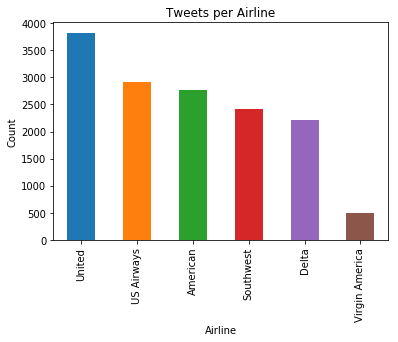

In [34]:
df.airline.value_counts().plot(kind = "bar")
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('Tweets per Airline')

Text(0.5,1,'Categories of Sentiments')

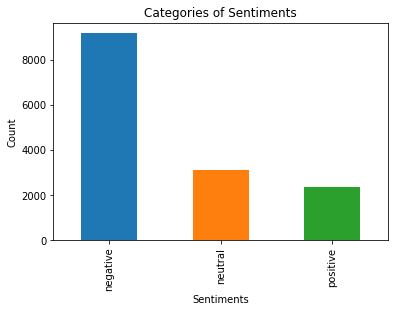

In [30]:
df.airline_sentiment.value_counts().plot(kind = "bar")
plt.xlabel('Sentiments')
plt.ylabel('Count')
plt.title('Categories of Sentiments')

Text(0.5,1,'Sentiment by Airline')

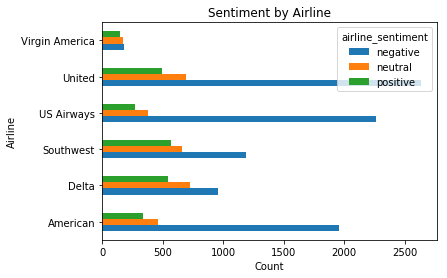

In [3]:
airline_sentiment=pd.crosstab(df.airline, df.airline_sentiment).plot(kind='barh')
airline_sentiment
plt.xlabel('Count')
plt.ylabel('Airline')
plt.title('Sentiment by Airline')

# Add Ratio comparison

In [49]:
air_sentiment=pd.crosstab(df.airline, df.airline_sentiment)
air_sentiment

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


Text(0.5,1,'Sentiment by Airline - Stacked')

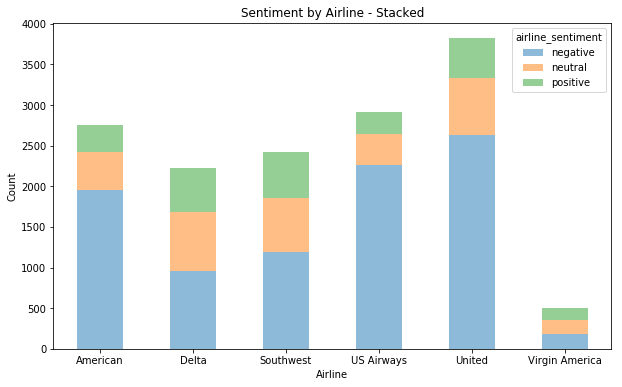

In [55]:
pd.crosstab(index = df.airline, columns = df.airline_sentiment).plot(kind='bar',
                figsize=(10, 6),alpha=0.5,rot=0,stacked=True)
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('Sentiment by Airline - Stacked')

In [50]:
sent_percent=air_sentiment.apply(lambda a: a / a.sum() * 100, axis=1)
sent_percent

airline_sentiment,negative,neutral,positive
airline,,,
American,71.040232,16.781443,12.178325
Delta,42.979298,32.538254,24.482448
Southwest,49.008264,27.438017,23.553719
US Airways,77.686234,13.079300,9.234466
United,68.890633,18.236525,12.872841
Virgin America,35.912698,33.928571,30.158730


Text(0.5,1,'Sentiment by Airline - Ratio')

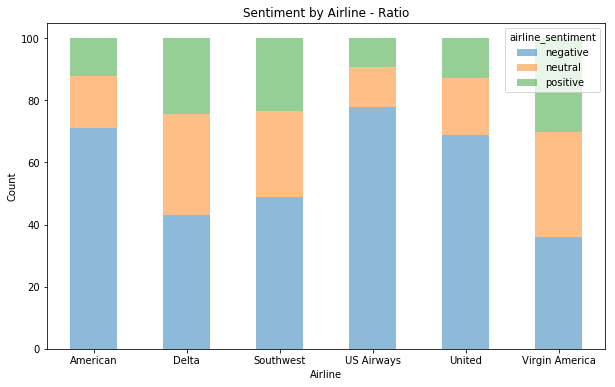

In [54]:
sent_percent.plot(kind='bar', figsize=(10, 6), alpha=0.5, rot=0, stacked=True)
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('Sentiment by Airline - Ratio')

In [5]:
df.negativereason.describe()

count                       9178
unique                        10
top       Customer Service Issue
freq                        2910
Name: negativereason, dtype: object

In [6]:
df.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [65]:
df.negativereason.replace('longlines','Long Lines', inplace = True)

In [66]:
df.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
Long Lines                      178
Damaged Luggage                  74
Name: negativereason, dtype: int64

Text(0.5,1,'Negative Reason by Airline')

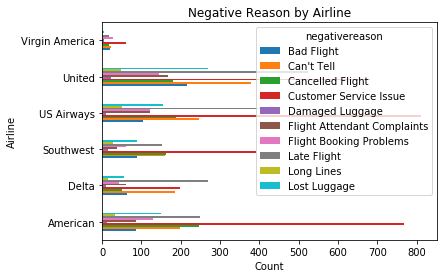

In [67]:
air_neg_sentiment=pd.crosstab(df.airline, df.negativereason).plot(kind='barh')
air_neg_sentiment
plt.xlabel('Count')
plt.ylabel('Airline')
plt.title('Negative Reason by Airline')

# Look at Ratios instead of counts

Text(0.5,1,'Categories of Negative Reasons')

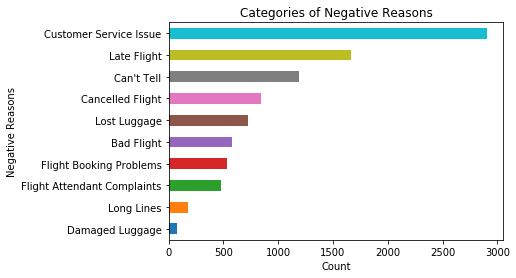

In [69]:
# Count of category occurence in data

# df.negativereason.value_counts().plot(kind = "bar")
# negreas = df.negativereason.value_counts(sort=True)

negreas = df.negativereason.value_counts().sort_values()
negreas.plot.barh()
plt.xlabel('Count')
plt.ylabel('Negative Reasons')
plt.title('Categories of Negative Reasons')

In [5]:
df.user_timezone.value_counts()

Eastern Time (US & Canada)     3744
Central Time (US & Canada)     1931
Pacific Time (US & Canada)     1208
Quito                           738
Atlantic Time (Canada)          497
Mountain Time (US & Canada)     369
Arizona                         229
London                          195
Alaska                          108
Sydney                          107
Hawaii                          104
Amsterdam                        74
America/Chicago                  37
Indiana (East)                   26
America/New_York                 26
Paris                            25
Brasilia                         23
Abu Dhabi                        23
Dublin                           17
Santiago                         17
Greenland                        17
Tehran                           17
Athens                           16
America/Los_Angeles              15
New Delhi                        15
Mid-Atlantic                     15
Casablanca                       15
Buenos Aires                

In [32]:
df.tweet_location.value_counts()

Boston, MA                        157
New York, NY                      156
Washington, DC                    150
New York                          127
USA                               126
Chicago                           104
New York City                      96
Los Angeles, CA                    96
NYC                                95
San Francisco, CA                  91
San Francisco                      86
Chicago, IL                        81
Brooklyn, NY                       66
Los Angeles                        64
Austin, TX                         64
Washington, D.C.                   63
Boston                             62
Dallas, TX                         54
Washington DC                      53
Nashville, TN                      45
Texas                              42
NY                                 42
Philadelphia, PA                   38
San Diego                          38
Denver, CO                         37
Houston, TX                        35
Global      

In [44]:
print(df.text[0])

@VirginAmerica What @dhepburn said.


In [45]:
print(df.text[1])

@VirginAmerica plus you've added commercials to the experience... tacky.


In [46]:
print(df.text[2])

@VirginAmerica I didn't today... Must mean I need to take another trip!


In [47]:
print(df.text[3])

@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse


In [48]:
print(df.text[5])

@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA


In [4]:
print(df.text[6])

@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)


In [ ]:
# Research how to handle emojis